In [28]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid", context='notebook', color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

The goal of this notebook is to find a classification model that predicts if given user behaviour will lead to booking.

Prerequisites:
- Run ./notebooks/Data Exploration.ipynb - it will remove duplicates and handle missing values for the raw dataset
- Run ./notebooks/Feature Engineering.ipynb - it creates new features and tranforms the raw dataset into a format that is readable by machine learning model. The resulting dataset is saved in csv file (`data/transformed_dataset.csv`).


In [3]:
filepath = "data/transformed_dataset.csv"
df = pd.read_csv(filepath)

In [4]:
df.head()

,user_id,date_from,date_to,origin,destination,is_booked,search_count,num_adults,num_children,num_days,geo_distance
0,000069,2017-05-10,2017-05-26,FRA,ALG,0,1,2,3,16,1553.717725
1,00019d,2017-09-15,2017-10-13,PAR,SSA,0,1,4,0,28,7944.570036
2,0002e3,2017-05-01,2017-05-01,PAR,ATH,0,1,1,0,0,2095.453304
3,000332,2017-06-08,2017-07-07,NCE,TLV,0,3,1,0,29,2722.329760
4,000332,2017-06-08,2017-07-07,TLV,NCE,0,1,2,0,29,2722.329760


In [7]:
target_column = 'is_booked'
feature_columns = ['geo_distance', 'search_count', 'num_days', 'num_adults', 'num_children']

# Feature Selection
To identify the top 3 features that is highly dependent to our target variable(`is_booked`), I'll be using chi-square test of independence. If the chi-square value of a feature is high, that means the feature is highly dependent to our target variable. 

In [8]:
X = df[feature_columns]
y = df[target_column]

bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,y)
pd.DataFrame.from_dict({'Features': X.columns, 'Score': fit.scores_}).sort_values('Score', ascending=False)

,Features,Score
0,geo_distance,497889.616321
1,search_count,2724.818192
2,num_days,1134.571257
4,num_children,14.673743
3,num_adults,10.788184


On the above table, `geo_distance`, `search_count` and `num_days` are the top 3 features with high chi-square value.
Let's try training our Logistic Regression with the top 3 features.

In [9]:
feature_columns = ['geo_distance', 'search_count', 'num_days']

# Split the dataset into training and test dataset

In [10]:
X = df[feature_columns]
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)

### Let's check if the training dataset is balanced

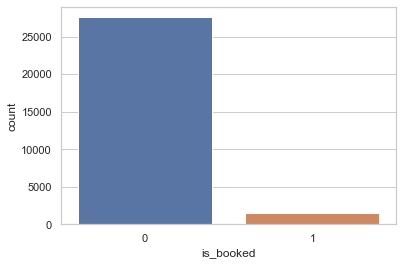

In [11]:
temp = pd.DataFrame(y_train, index=y_train.index)
sns.countplot(x='is_booked', data=temp)

In [12]:
temp['is_booked'].value_counts()

0    27579
1     1445
Name: is_booked, dtype: int64

There are 27579 rows that are only search data and 1445 rows that are booked data. Thus, we have an imbalanced training dataset.

Since we have an imbalanced dataset, we need to apply oversampling on minority class(`is_booked = 1`) in our training dataset so that we have a balance training dataset.


### Apply SMOTE algorithm to make our training dataset balance

In [13]:
# Using SMOTE algorithm, I created a synthetic sample data 
# so that the number of users who booked and did not booked will be the same.

sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train_syn, y_train_syn = sm.fit_resample(X_train, y_train) 

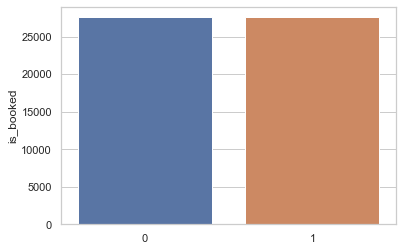

In [14]:
y_train_syn_value_counts = y_train_syn.value_counts()
sns.barplot(x=y_train_syn_value_counts.index, y=y_train_syn_value_counts)

In [15]:
y_train_syn.value_counts()

1    27579
0    27579
Name: is_booked, dtype: int64

After applying SMOTE algorithm to our minority class (1 refers users who have book event_type), we now have the same number of 0 and 1.

### Normalizing dataset
Since the columns of our dataset are of different ranges, let's normalize the column values in the range of 0 and 1.


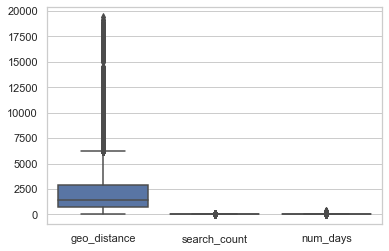

In [16]:
# dataset ranges before normalization
sns.boxplot(data=X_train_syn)

In [17]:
norm = MinMaxScaler().fit(X_train_syn)
X_train_norm = norm.transform(X_train_syn)
X_test_norm = norm.transform(X_test)

Columns are now on the same range after normalizing the columns based on minimum and maximum values for each column.

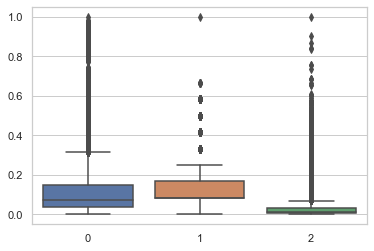

In [18]:
sns.boxplot(data=X_train_norm)

### Generating a classification algorithm
Let's generate a classification model using LogisticRegression.

In [19]:
clf = LogisticRegression(random_state=123).fit(X_train_norm, y_train_syn)

In [20]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [21]:
y_pred = clf.predict(X_test_norm)

In [22]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[6113  782]
 [ 111  250]]


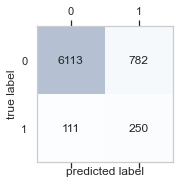

In [23]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.grid()
plt.show()

In [24]:
def generate_model_report(y_actual, y_predicted):
    print(f"Accuracy = {accuracy_score(y_actual, y_predicted)}")
    print(f"Precision = {precision_score(y_actual, y_predicted)}")
    print(f"Recall = {recall_score(y_actual, y_predicted)}")
    print(f"F1 Score = {f1_score(y_actual, y_predicted)}")

In [25]:
generate_model_report(y_test, y_pred)

Accuracy = 0.8769294377067255
Precision = 0.24224806201550386
Recall = 0.6925207756232687
F1 Score = 0.3589375448671931


This logistic regression model will be our base model with default parameters. The accuracy score of the model is `0.876929`.

# Hyperparameter Tuning
Let's see if we can improve our base model by tuning the parameters in Logistic Regression using grid search.

In [26]:
hyperparameters = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
}

In [32]:
random_logistic_class = GridSearchCV(
    estimator=LogisticRegression(random_state=123),
    param_grid=hyperparameters,
    scoring="accuracy",
    n_jobs=2,
    cv=10,
    refit=True,
    return_train_score=True
)

In [40]:
random_logistic_class.fit(X_train_norm, y_train_syn)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=123), n_jobs=2,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='accuracy')

In [41]:
y_pred_1 = random_logistic_class.best_estimator_.predict(X_test_norm)
generate_model_report(y_test, y_pred_1)

Accuracy = 0.8767916207276737
Precision = 0.2420135527589545
Recall = 0.6925207756232687
F1 Score = 0.35868005738880915


In [42]:
random_logistic_class.best_estimator_

LogisticRegression(C=100, random_state=123)

In [43]:
random_logistic_class.best_params_

{'C': 100, 'penalty': 'l2'}

Based on the accuracy score, the best model in grid search with cross validation of 10 have `0.87679` while our base model(no cross validation) has `0.876929`.

In [44]:
# a helper method to find the best model. 
# it is an aggregation of splitting dataset, oversampling of minority class, normalizing dataset,
# then applying Logistic Regression
def find_best_model(dataset, feature_columns, target_column, grid_search_cv):
    X = df[feature_columns]
    y = df[target_column]
    #splitting data into training and test dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)
    
    # apply SMOTE algorithm to oversample minority class in imbalance dataset
    sm = SMOTE(random_state=123, sampling_strategy=1.0)
    X_train_syn, y_train_syn = sm.fit_resample(X_train, y_train)
    
    #normalize data in our dataset
    norm = MinMaxScaler().fit(X_train_syn)
    X_train_norm = norm.transform(X_train_syn)
    X_test_norm = norm.transform(X_test)
    
  
    grid_search_cv.fit(X_train_norm, y_train_syn)
    y_pred = grid_search_cv.best_estimator_.predict(X_test_norm)
    print(grid_search_cv.best_params_)
    generate_model_report(y_test, y_pred)
    
    return grid_search_cv

Now, let's try adding more features to our dataset and see if we can improve the accuracy.
Let's add `num_children` and `num_adults` to our training dataset.

In [45]:
random_logistic_class = GridSearchCV(
    estimator=LogisticRegression(random_state=123),
    param_grid=hyperparameters,
    scoring="accuracy",
    n_jobs=2,
    cv=10,
    refit=True,
    return_train_score=True
)
    
feature_columns = ['search_count', 'geo_distance', 'num_days', 'num_children', 'num_adults']
logistic_model = find_best_model(df, feature_columns, 'is_booked', random_logistic_class)

{'C': 1000, 'penalty': 'l2'}
Accuracy = 0.8849228224917309
Precision = 0.2467948717948718
Recall = 0.6398891966759003
F1 Score = 0.3562066306861989


### Adding 2 more features in our training dataset, it improves the accuracy score of the Logistic Regression to `0.884923`, which is higher than our base model's accuracy of `0.876929`

# DecisionTree Classifier
Let's try running tree based classifier and see if we can find a model with accuracy score that is higher than our previous model.

In [46]:
parameters = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [0.04, 0.06, 0.08],
    'max_features': [0.2, 0.4, 0.6, 0.8]
}
grid_cv = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=123),
    param_grid=parameters,
    scoring="accuracy",
    n_jobs=-1,
    cv=10
)
    
feature_columns = ['search_count', 'geo_distance', 'num_days', 'num_adults', 'num_children']
find_best_model(df, feature_columns, 'is_booked', grid_cv)

{'max_depth': 3, 'max_features': 0.4, 'min_samples_leaf': 0.04}
Accuracy = 0.8807883131201764
Precision = 0.26709796672828096
Recall = 0.8005540166204986
F1 Score = 0.4005544005544005


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.04, 0.06, 0.08]},
             scoring='accuracy')

The highest accuracy score of the tree based model is `0.880788`. It is lower than the previous model's accuracy score of `0.884923`

# Conclusion

The best model that fits our dataset is LogisticRegression with parameter C = `1000` and penalty = `l2`. 
The accuracy score of the model is `0.884923`.

In [47]:
logistic_model.best_estimator_

LogisticRegression(C=1000, random_state=123)

In [48]:
logistic_model.best_params_

{'C': 1000, 'penalty': 'l2'}